In [1]:
import numpy as np
import matplotlib.pyplot as plt

def get_sequence(c_el, m_load, hour):

    PLOT, PRINT = True, False
    
    # Initialize the sequence with 2s (0=off, 1=on, 2=undetermined)
    sequence = 2*np.ones(len(c_el))

    # Depending on the type of load, the sequence will not be the same
    if round(np.mean(m_load),2) >= 0.10: load_type = "High load"
    elif round(np.mean(m_load),2) >= 0.05: load_type = "Medium load"
    else: load_type = "Low load"
    if PRINT: print(load_type)
        
    # For every hour in the next 24 hours
    for i in range(len(c_el)):

        # Always turn off the heat pump in high price periods
        if c_el[i] > 20: sequence[i] = 0

        # Always turn on the heat pump in negative price periods
        if c_el[i] < 0: sequence[i] = 1

        # Detect peaks, and their length
        if i<(len(c_el)-1) and abs(c_el[i+1] - c_el[i]) >= 15:
            if c_el[i+1] - c_el[i] > 0 and c_el[i+1]>20:
                length = i
                if PRINT: print(f"Price peak starting at {i+1}h")
            if c_el[i+1] - c_el[i] < 0  and c_el[i]>20:
                length = i - length
                if PRINT: print(f"Price peak finishing at {i+1}h, after {length} hours\n")

                # Depending on the load type, the minimum number of hours to charge before an x hour peak is not the same
                if load_type == "High load":
                    hours_charge = length
                elif load_type == "Medium load":
                    hours_charge = int(round(length/2 + 0.001)) if length>=2 else 1
                elif load_type == "Low load":
                    hours_charge = int(round(length/3 + 0.001)) if length>=3 else 1

                # Charge the tanks for as long as necessary before the peak
                for j in range(hours_charge):
                    # Hours that are still undefined are turned on
                    if sequence[i-length-j] == 2:
                        sequence[i-length-j] = 1
                    # Hours that were supposed to be turned off are turned on (this setting can change)
                    if sequence[i-length-j] == 0:
                        sequence[i-length-j] = 1
                        if hour < i-length+3-hours_charge:
                            print(f"\nNeed to charge more before peak {i+1-length}h-{i+1}h.")
                            print("Current setting is to use normally off periods to charge.")

    # Get the indices of the hours with remaining undertermined state
    two_option_indices = [1 if x==2 else np.nan for x in sequence]

    # If the current hour is in an undetermined state, try running it with the HP off
    if sequence[hour] == 2: sequence[hour] = 0
        
    # All other undetermined hours are kept as on for now (as long as it is not their turn)
    sequence = [1 if x==2 else int(x) for x in sequence]

    if PLOT:
        
        # Split electricity price in past and future hours
        c_el_future = [np.nan]*(hour-1) + c_el[hour-1:] if hour>0 else [np.nan]*(hour) + c_el[hour:]
        c_el_past = c_el[:hour] + [np.nan]*(len(c_el)-hour)

        # Split sequence in past and future hours
        sequence_future = [np.nan]*(hour-1) + sequence[hour-1:] if hour>0 else [np.nan]*hour + sequence[hour:]
        sequence_past = sequence[:hour] + [np.nan]*(len(c_el)-hour)

        # Highlight hours with undetermined mode
        two_option_indices_plot = [np.nan]*hour + two_option_indices[hour:]

        # Duplicate the final element of each plotted list to extend it midnight
        c_el_future = c_el_future + [c_el_future[-1]]
        c_el_past = c_el_past + [c_el_past[-1]]
        sequence_future = sequence_future + [sequence_future[-1]]
        sequence_past = sequence_past + [sequence_past[-1]]
        two_option_indices_plot = two_option_indices_plot + [two_option_indices_plot[-1]]
        
        # Plot the past and future electricity prices and load
        fig, ax = plt.subplots(1,1, figsize=(12,4), sharex=True)
        ax.step(range(len(c_el)+1), c_el_future, where='post', alpha=0.4, color='black', linestyle='dashed')
        ax.step(range(len(c_el)+1), c_el_past, where='post', alpha=0.6, color='black')
        ax.set_xticks(range(len(c_el)+1))
        ax.set_xlim([-1,len(c_el)+1])
        ax.set_ylim([-10,45])
        ax2 = ax.twinx()
        ax2.step(range(len(c_el)+1), sequence_future, where='post', color='blue', alpha=0.6, linestyle='dashed')
        ax2.step(range(len(c_el)+1), sequence_past, where='post', color='blue', alpha=0.6)
        ax2.step(range(len(c_el)+1), two_option_indices_plot, where='post', color='red', alpha=0.9)
        ax2.set_yticks([0,1])
        ax2.set_ylim([-0.7,1.7])
        
        # Highlight the area corresponding to the horizon
        plt.axvline(x=hour, color='green', linestyle='dotted',alpha=0.2)
        plt.axvline(x=hour+8, color='green', linestyle='dotted',alpha=0.2)
        plt.axvspan(hour, hour+8, facecolor='green', alpha=0.05, label='Highlight')
        
        # Plot title
        plt.title(f"{load_type}") if two_option_indices[hour]!=1 else plt.title(f"{load_type} - two options")
        plt.show()

    # Trim the sequence to fit the 8-hour horizon
    sequence_trimmed = sequence[hour:] + [1] * hour
    sequence_trimmed = sequence_trimmed[:8]

    # Check if yes or no there are two options
    undertermined_now = two_option_indices[hour] == 1

    return sequence_trimmed, undertermined_now

In [2]:
# Low load
m_load = [0.04, 0.04, 0.05, 0.05, 0.05, 0.04, 0.04, 0.03, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.02, 0.03, 0.03, 0.04]
# Medium load
m_load = [0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.1, 0.1, 0.08, 0.08, 0.08, 0.08, 0.08, 0.07, 0.07, 0.07, 0.07, 0.07, 0.09, 0.09, 0.1, 0.1, 0.11, 0.11]
# High load
m_load = [0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.15, 0.14, 0.14, 0.13, 0.13, 0.13, 0.13, 0.13, 0.14, 0.14, 0.14, 0.15, 0.15, 0.15, 0.15, 0.15]

print(f"The average load is {round(np.mean(m_load),2)} kg/s")

The average load is 0.15 kg/s


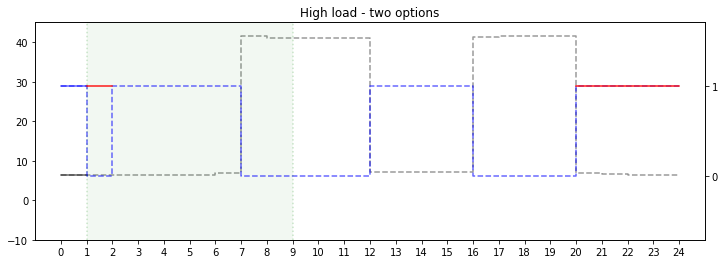

0h: [0, 1, 1, 1, 1, 1, 0, 0], True



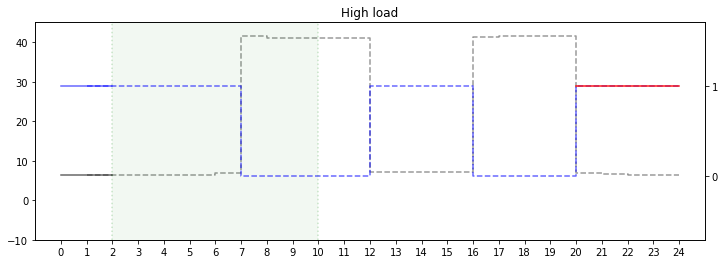

1h: [1, 1, 1, 1, 1, 0, 0, 0], False



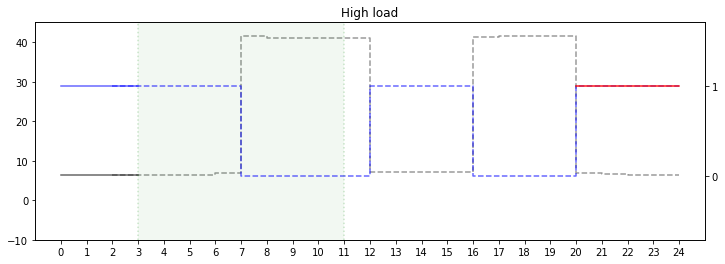

2h: [1, 1, 1, 1, 0, 0, 0, 0], False



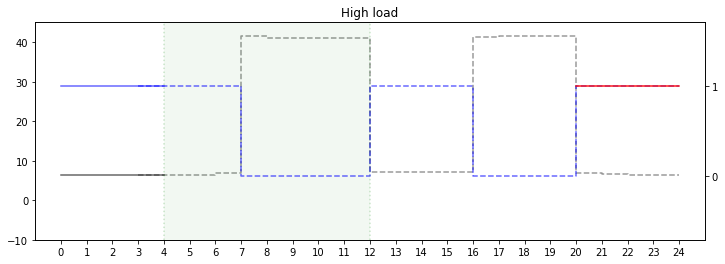

3h: [1, 1, 1, 0, 0, 0, 0, 0], False



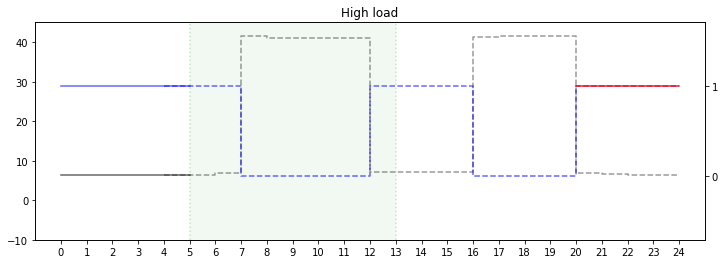

4h: [1, 1, 0, 0, 0, 0, 0, 1], False



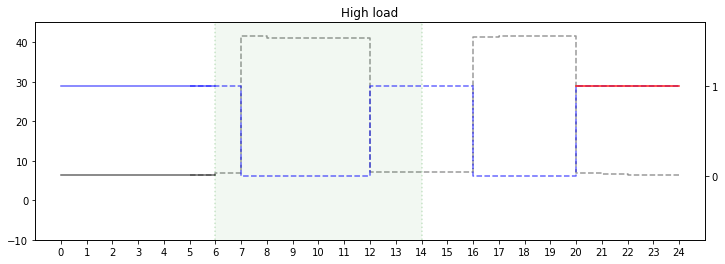

5h: [1, 0, 0, 0, 0, 0, 1, 1], False



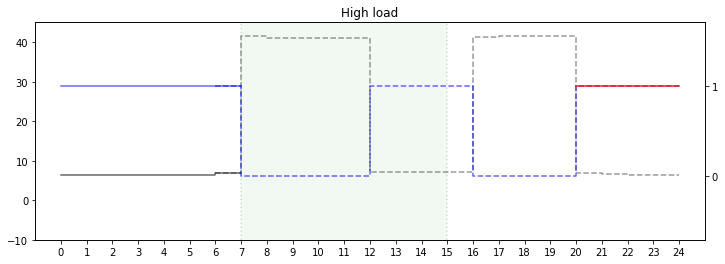

6h: [0, 0, 0, 0, 0, 1, 1, 1], False



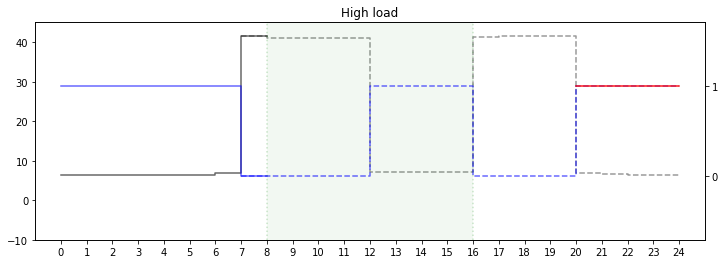

7h: [0, 0, 0, 0, 1, 1, 1, 1], False



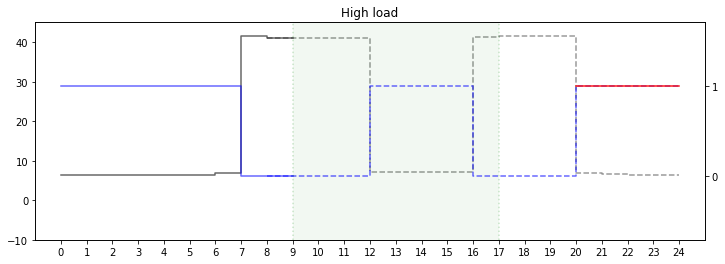

8h: [0, 0, 0, 1, 1, 1, 1, 0], False



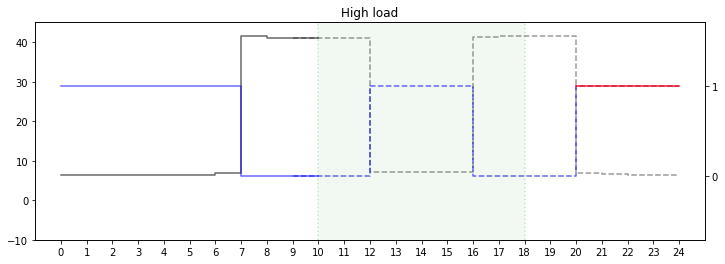

9h: [0, 0, 1, 1, 1, 1, 0, 0], False



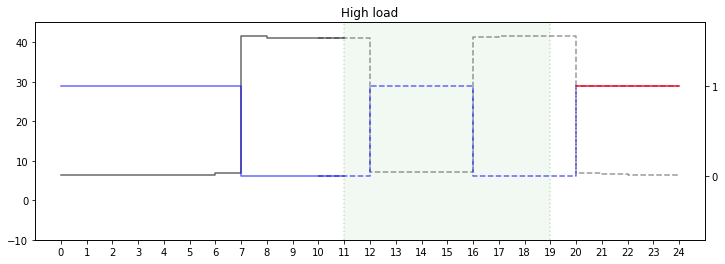

10h: [0, 1, 1, 1, 1, 0, 0, 0], False



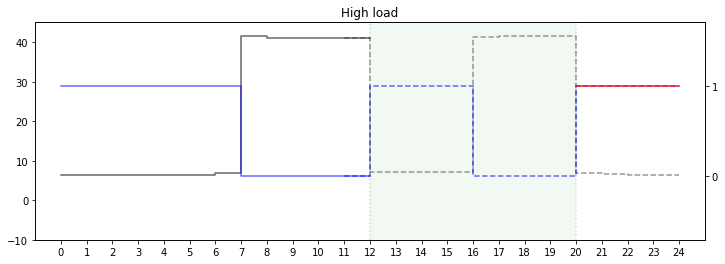

11h: [1, 1, 1, 1, 0, 0, 0, 0], False



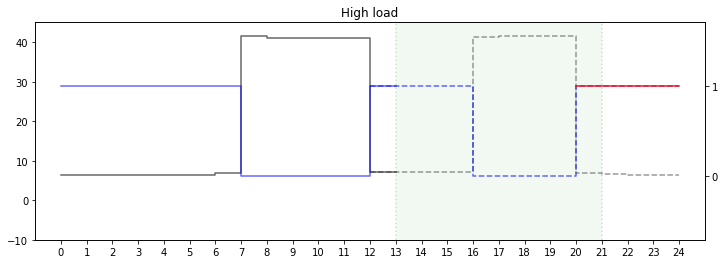

12h: [1, 1, 1, 0, 0, 0, 0, 1], False



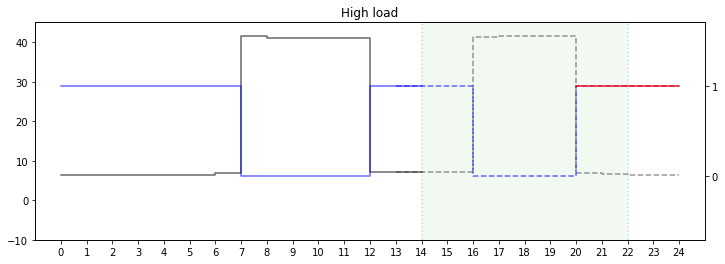

13h: [1, 1, 0, 0, 0, 0, 1, 1], False



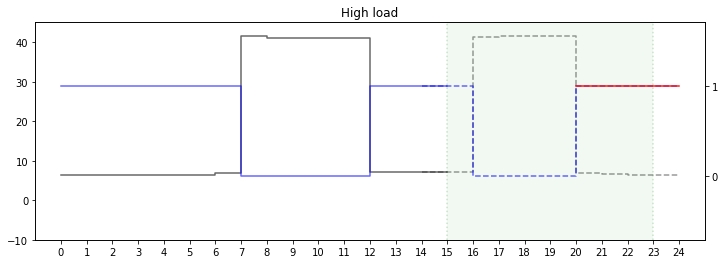

14h: [1, 0, 0, 0, 0, 1, 1, 1], False



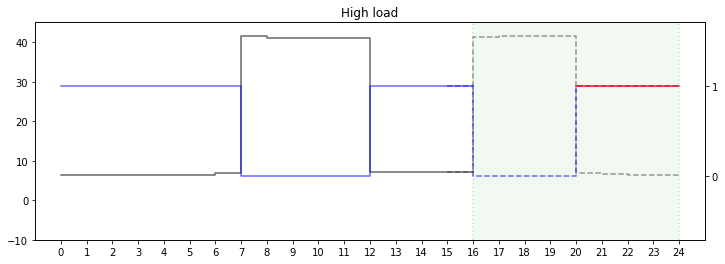

15h: [0, 0, 0, 0, 1, 1, 1, 1], False



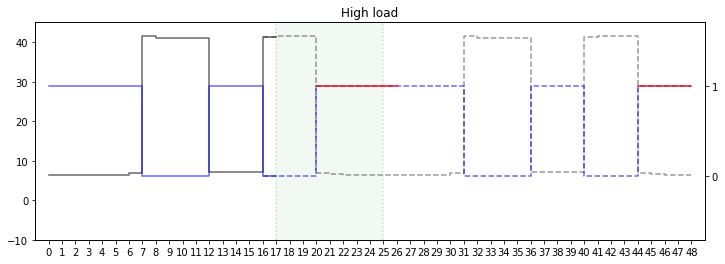

16h: [0, 0, 0, 1, 1, 1, 1, 1], False



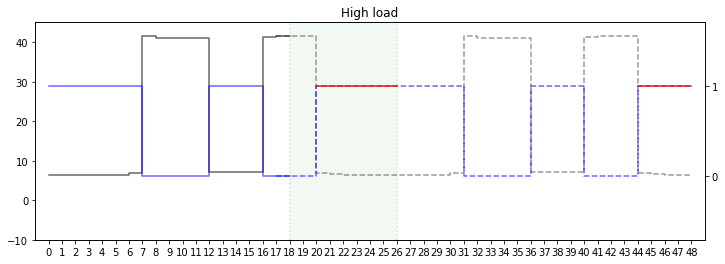

17h: [0, 0, 1, 1, 1, 1, 1, 1], False



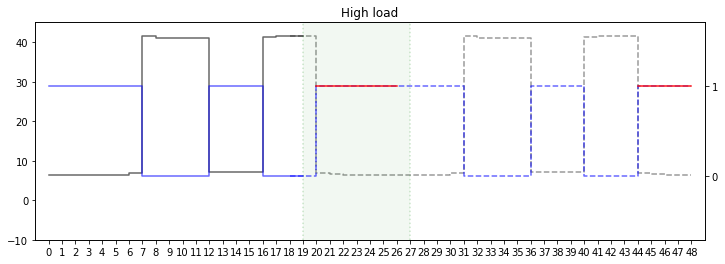

18h: [0, 1, 1, 1, 1, 1, 1, 1], False



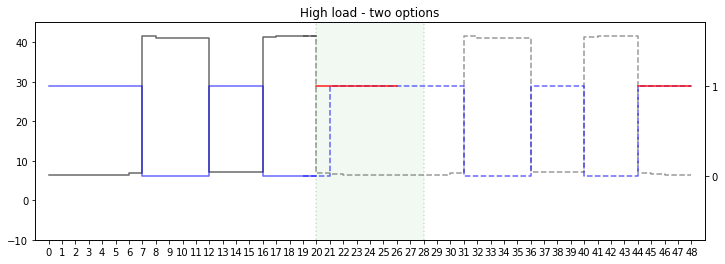

19h: [0, 1, 1, 1, 1, 1, 1, 1], True



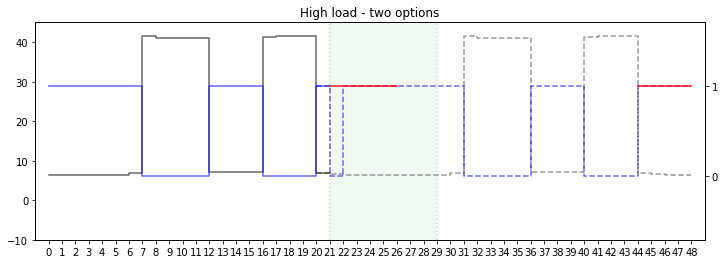

20h: [0, 1, 1, 1, 1, 1, 1, 1], True



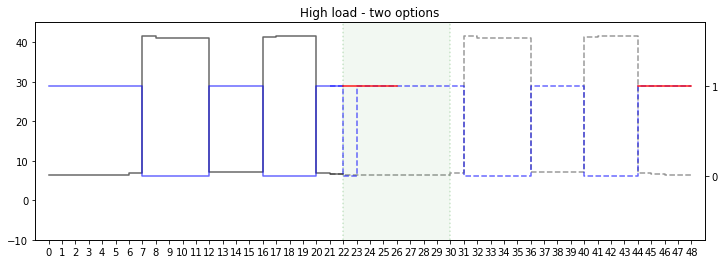

21h: [0, 1, 1, 1, 1, 1, 1, 1], True



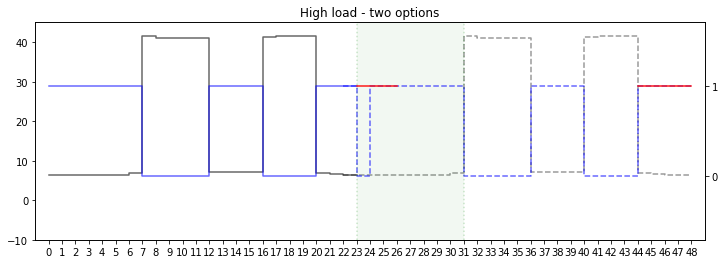

22h: [0, 1, 1, 1, 1, 1, 1, 1], True



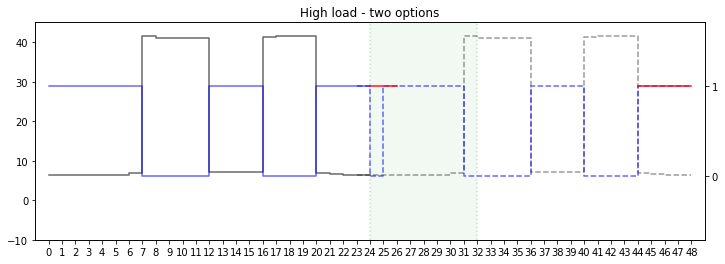

23h: [0, 1, 1, 1, 1, 1, 1, 0], True



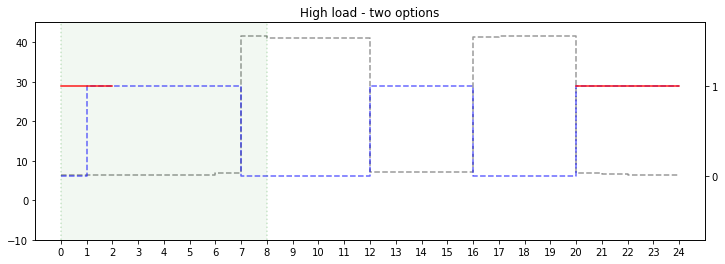

24h: [0, 1, 1, 1, 1, 1, 1, 0], True



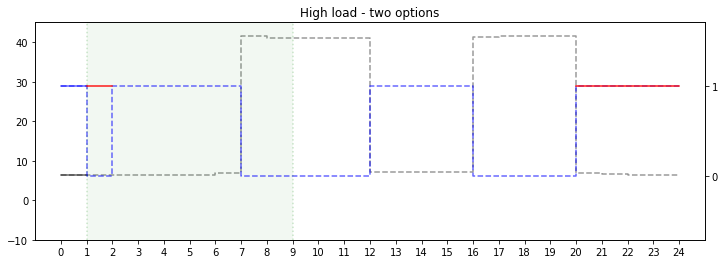

25h: [0, 1, 1, 1, 1, 1, 0, 0], True



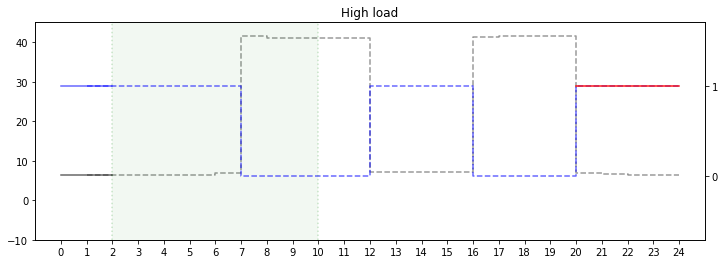

26h: [1, 1, 1, 1, 1, 0, 0, 0], False



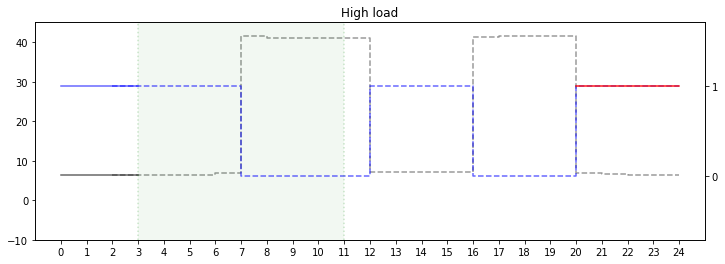

27h: [1, 1, 1, 1, 0, 0, 0, 0], False



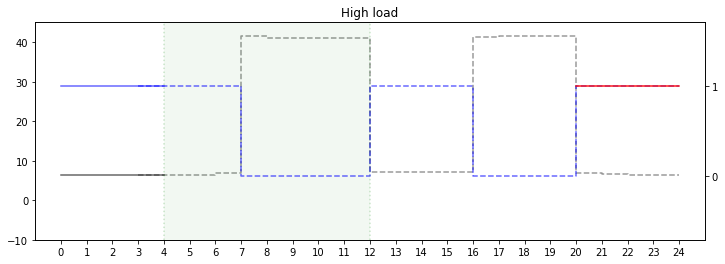

28h: [1, 1, 1, 0, 0, 0, 0, 0], False



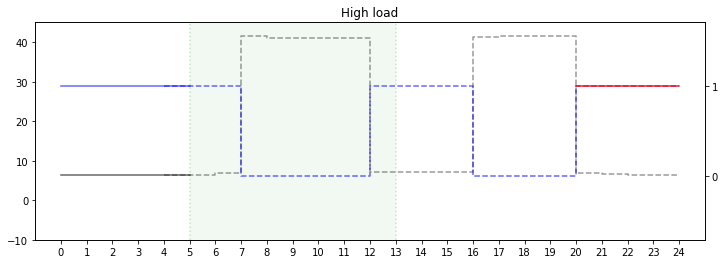

29h: [1, 1, 0, 0, 0, 0, 0, 1], False



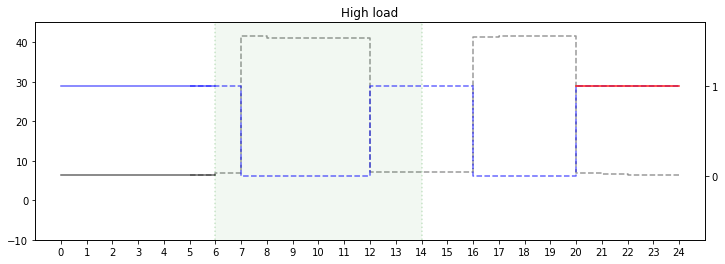

30h: [1, 0, 0, 0, 0, 0, 1, 1], False



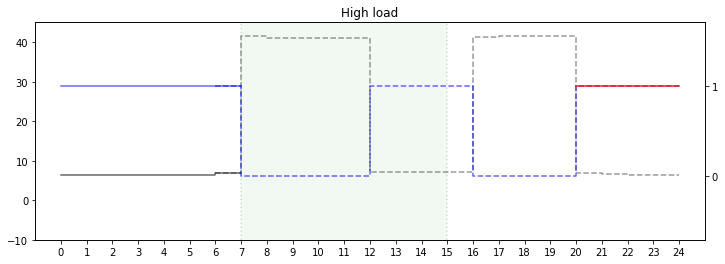

31h: [0, 0, 0, 0, 0, 1, 1, 1], False



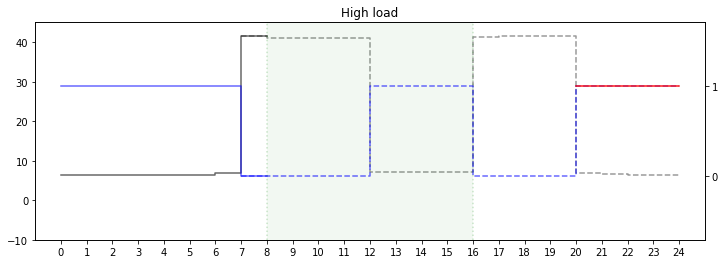

32h: [0, 0, 0, 0, 1, 1, 1, 1], False



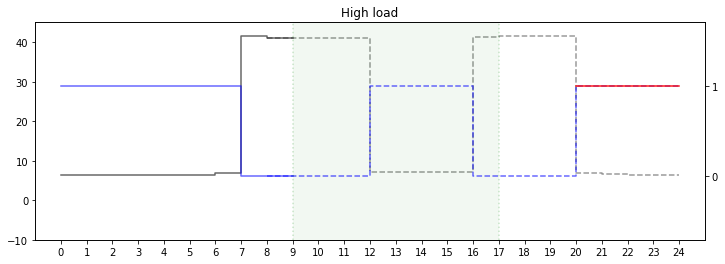

33h: [0, 0, 0, 1, 1, 1, 1, 0], False



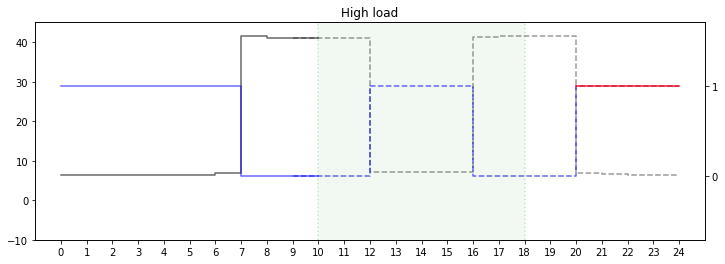

34h: [0, 0, 1, 1, 1, 1, 0, 0], False



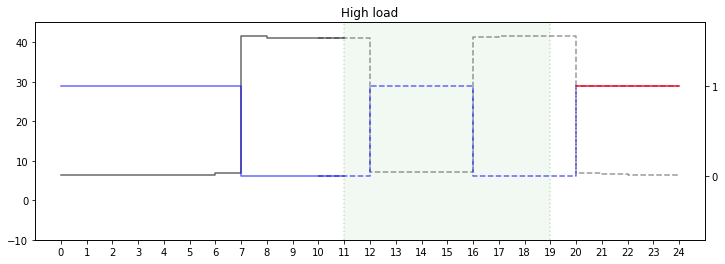

35h: [0, 1, 1, 1, 1, 0, 0, 0], False



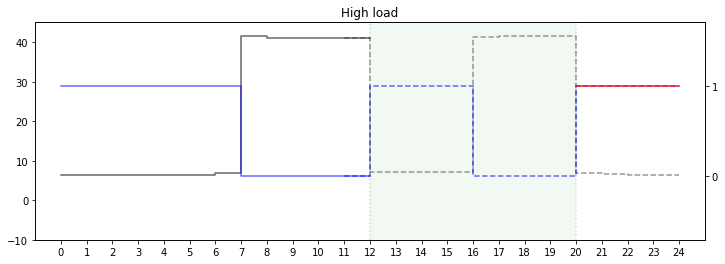

36h: [1, 1, 1, 1, 0, 0, 0, 0], False



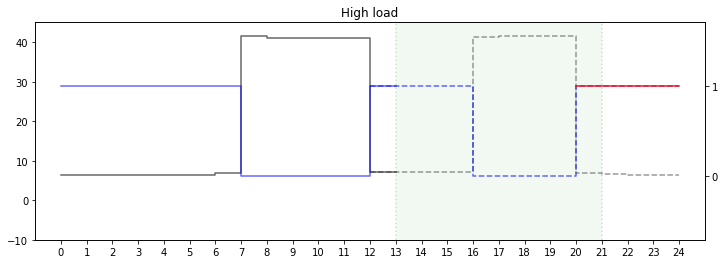

37h: [1, 1, 1, 0, 0, 0, 0, 1], False



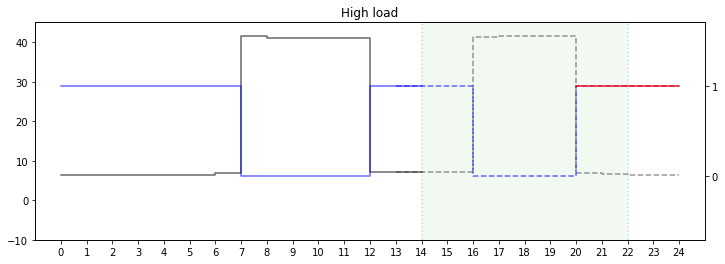

38h: [1, 1, 0, 0, 0, 0, 1, 1], False



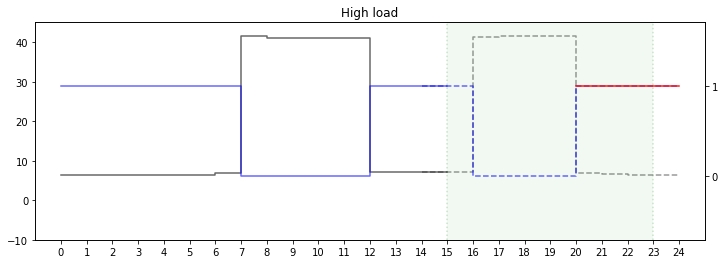

39h: [1, 0, 0, 0, 0, 1, 1, 1], False



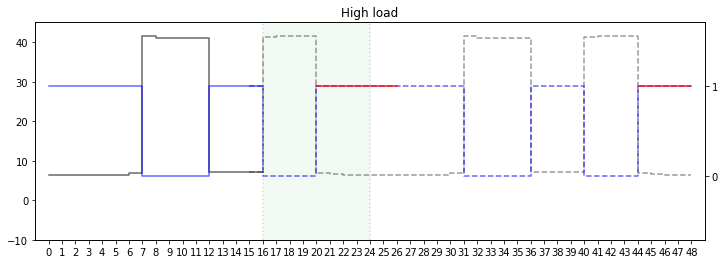

40h: [0, 0, 0, 0, 1, 1, 1, 1], False



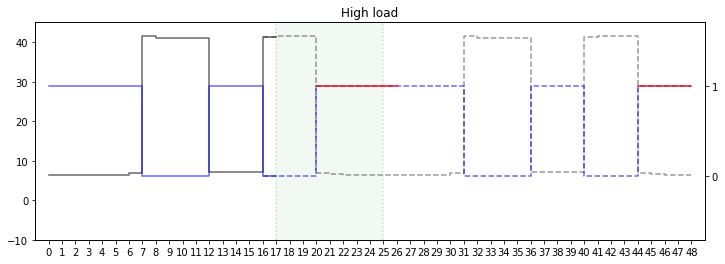

41h: [0, 0, 0, 1, 1, 1, 1, 1], False



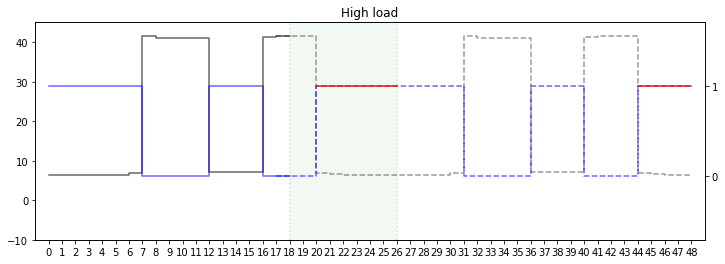

42h: [0, 0, 1, 1, 1, 1, 1, 1], False



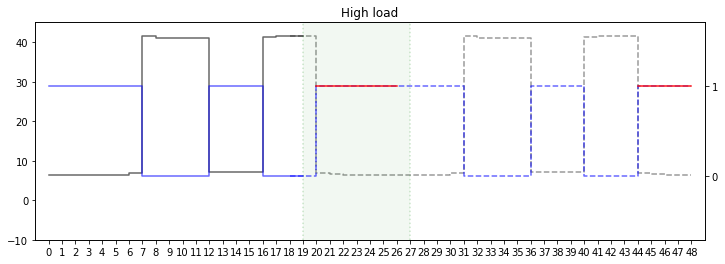

43h: [0, 1, 1, 1, 1, 1, 1, 1], False



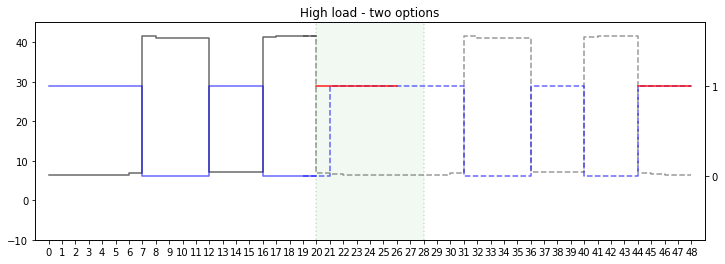

44h: [0, 1, 1, 1, 1, 1, 1, 1], True



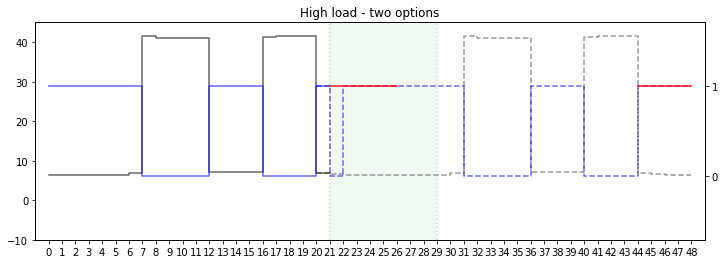

45h: [0, 1, 1, 1, 1, 1, 1, 1], True



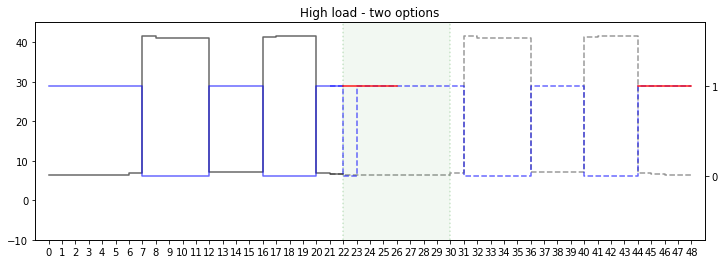

46h: [0, 1, 1, 1, 1, 1, 1, 1], True



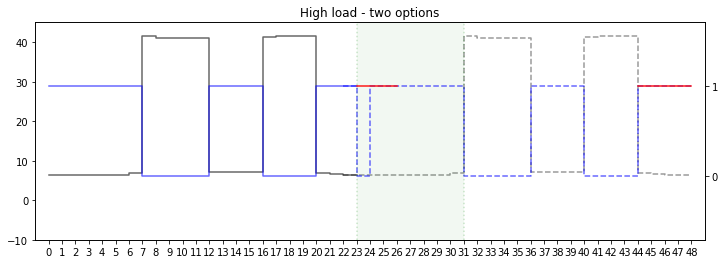

47h: [0, 1, 1, 1, 1, 1, 1, 1], True



In [3]:
# Scenario 1 - forecasts = reality
c_el = [6.36, 6.34, 6.34, 6.4, 6.41, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
iter_eff = 0

for iter in range(48):
    for k in range(30):
        if iter==16+k*24: 
            c_el = c_el + c_el[:24]
        if iter==24+k*24: 
            c_el = c_el[:24]
            iter_eff=-1
    iter_eff+=1

    sequence, two_options = get_sequence(c_el, m_load, iter_eff)
    print(f"{iter}h: {sequence}, {two_options}\n")

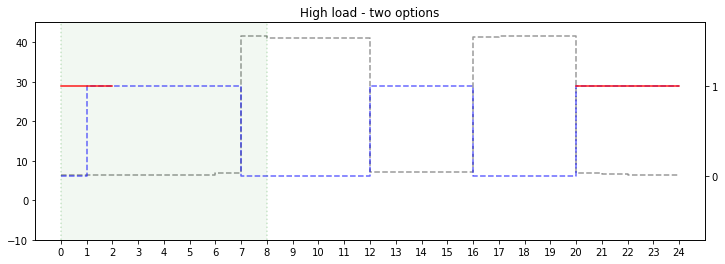

0h: [0, 1, 1, 1, 1, 1, 1, 0], True



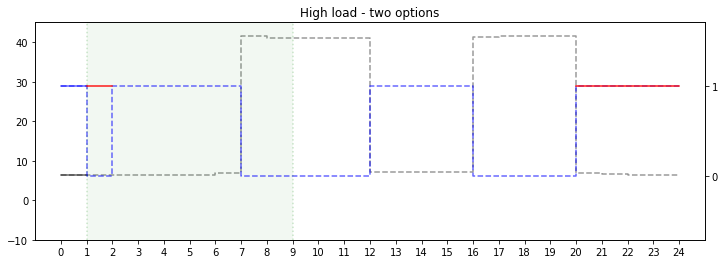

1h: [0, 1, 1, 1, 1, 1, 0, 0], True



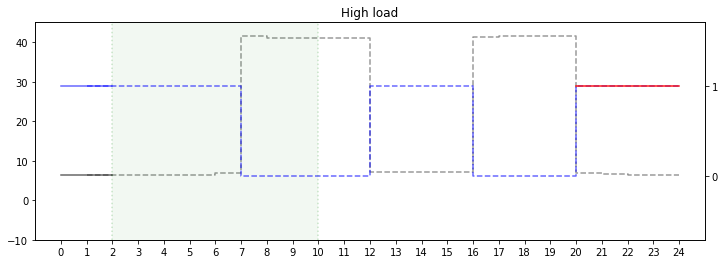

2h: [1, 1, 1, 1, 1, 0, 0, 0], False



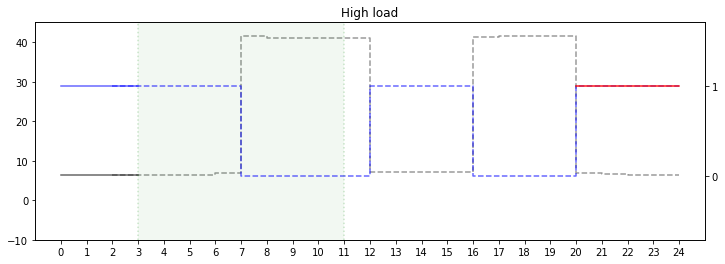

3h: [1, 1, 1, 1, 0, 0, 0, 0], False



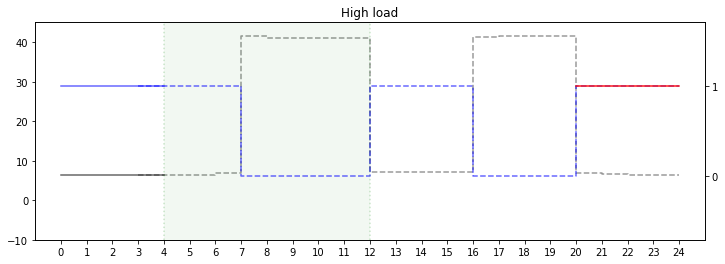

4h: [1, 1, 1, 0, 0, 0, 0, 0], False



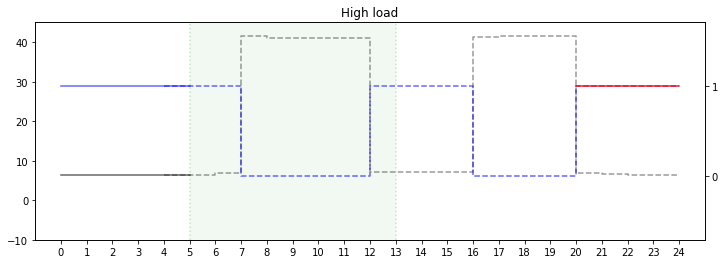

5h: [1, 1, 0, 0, 0, 0, 0, 1], False



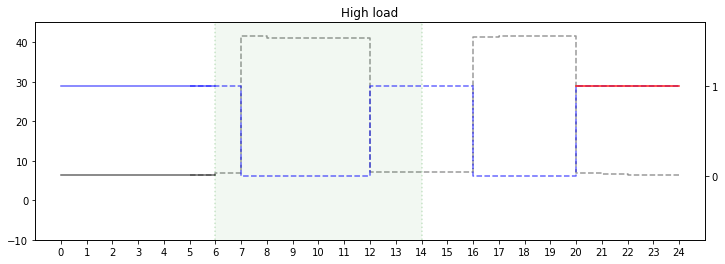

6h: [1, 0, 0, 0, 0, 0, 1, 1], False



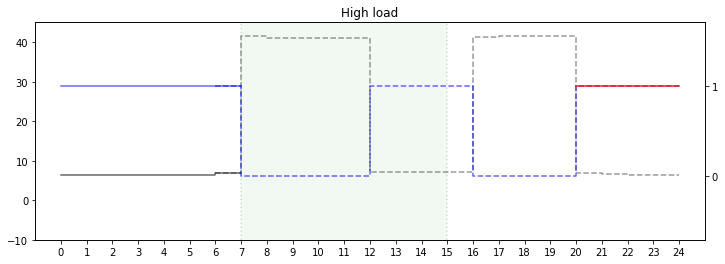

7h: [0, 0, 0, 0, 0, 1, 1, 1], False



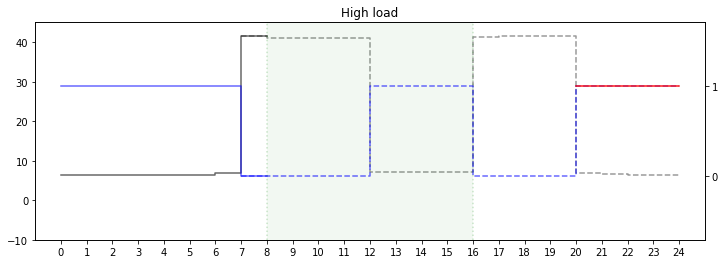

8h: [0, 0, 0, 0, 1, 1, 1, 1], False


Need to charge more before peak 10h-12h.
Current setting is to use normally off periods to charge.


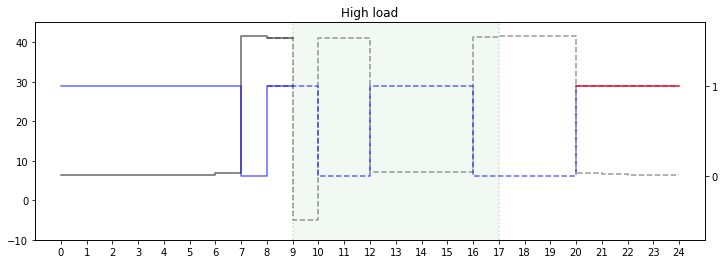

9h: [1, 0, 0, 1, 1, 1, 1, 0], False



In [4]:
# Scenario 2
c_el = [6.36, 6.34, 6.34, 6.4, 6.41, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
for iter in range(10):
    if iter==16:
        c_el = c_el + c_el
    if iter==9:
        c_el = [6.36, 6.34, 6.34, 6.41, 6.41, 6.46, 6.95, 41.51, 41.16, -5.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
    sequence, two_options = get_sequence(c_el, m_load, iter)
    print(f"{iter}h: {sequence}, {two_options}\n")

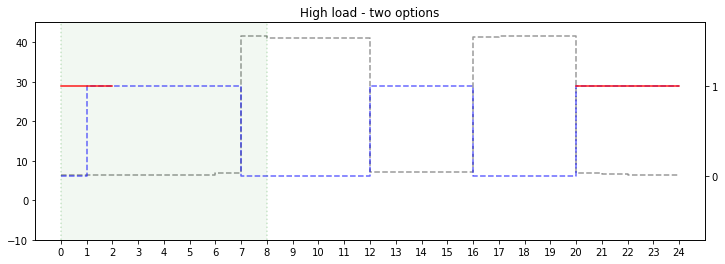

0h: [0, 1, 1, 1, 1, 1, 1, 0], True



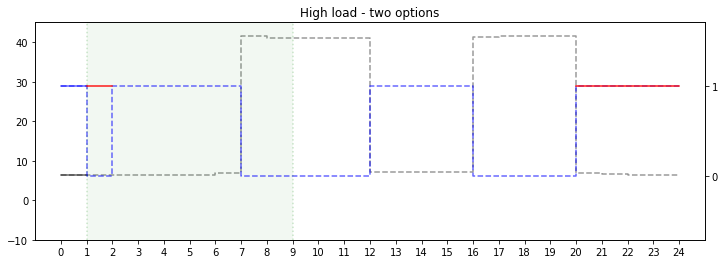

1h: [0, 1, 1, 1, 1, 1, 0, 0], True



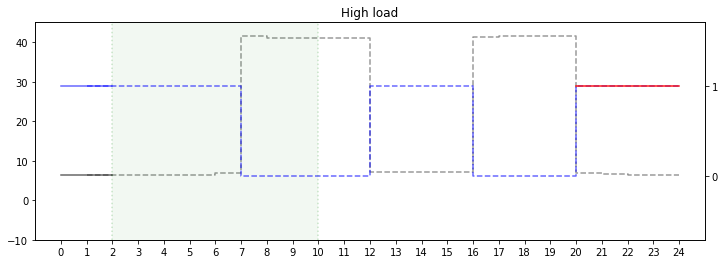

2h: [1, 1, 1, 1, 1, 0, 0, 0], False


Need to charge more before peak 7h-12h.
Current setting is to use normally off periods to charge.


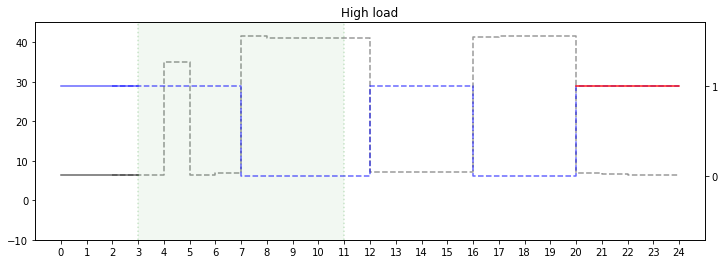

3h: [1, 1, 1, 1, 0, 0, 0, 0], False



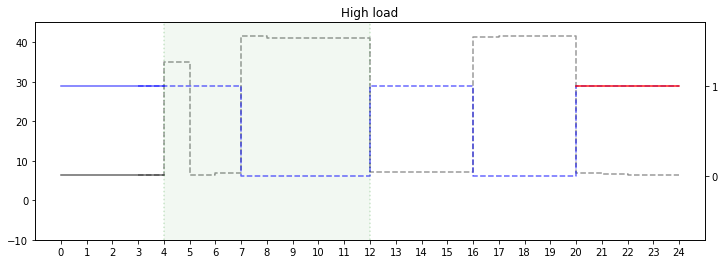

4h: [1, 1, 1, 0, 0, 0, 0, 0], False



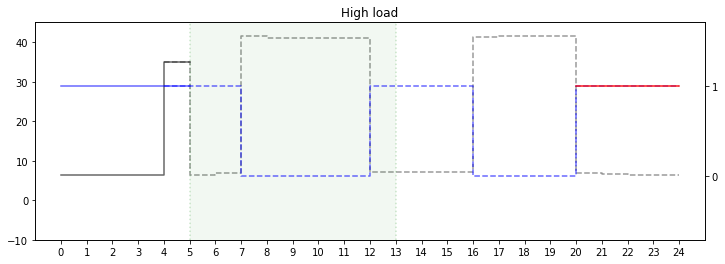

5h: [1, 1, 0, 0, 0, 0, 0, 1], False



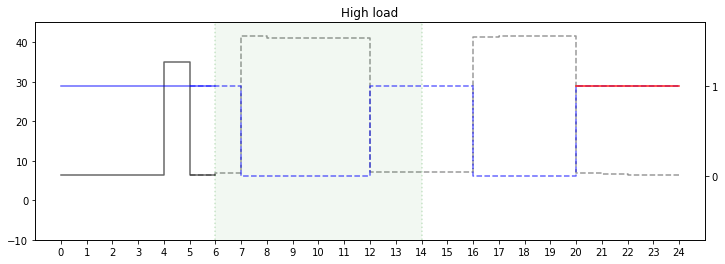

6h: [1, 0, 0, 0, 0, 0, 1, 1], False



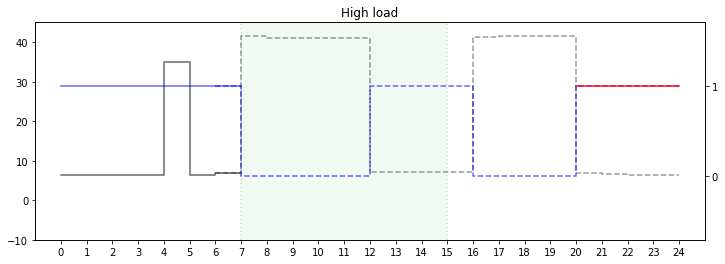

7h: [0, 0, 0, 0, 0, 1, 1, 1], False



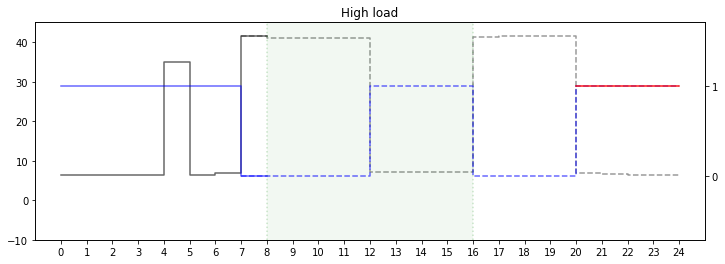

8h: [0, 0, 0, 0, 1, 1, 1, 1], False



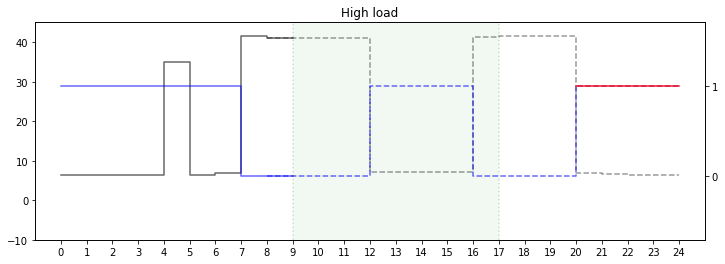

9h: [0, 0, 0, 1, 1, 1, 1, 0], False



In [5]:
# Scenario 2
c_el = [6.36, 6.34, 6.34, 6.4, 6.41, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
for iter in range(10):
    if iter==16:
        c_el = c_el + c_el
    if iter==3:
        c_el = [6.36, 6.34, 6.34, 6.41, 35, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
    sequence, two_options = get_sequence(c_el, m_load, iter)
    print(f"{iter}h: {sequence}, {two_options}\n")

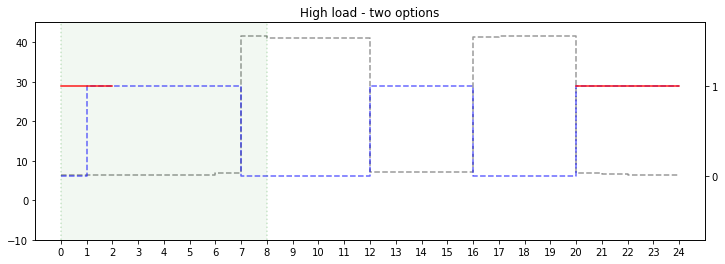

0h: [0, 1, 1, 1, 1, 1, 1, 0], True



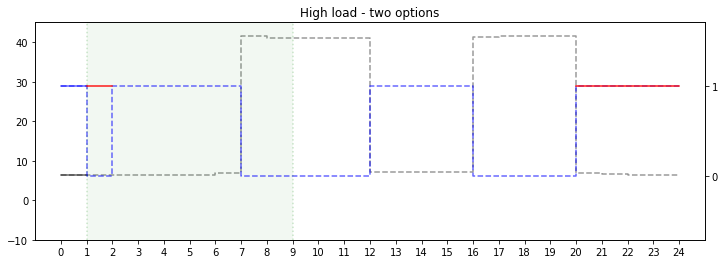

1h: [0, 1, 1, 1, 1, 1, 0, 0], True



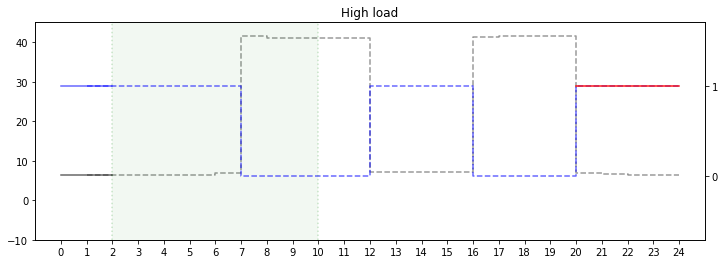

2h: [1, 1, 1, 1, 1, 0, 0, 0], False


Need to charge more before peak 7h-12h.
Current setting is to use normally off periods to charge.

Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.

Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.


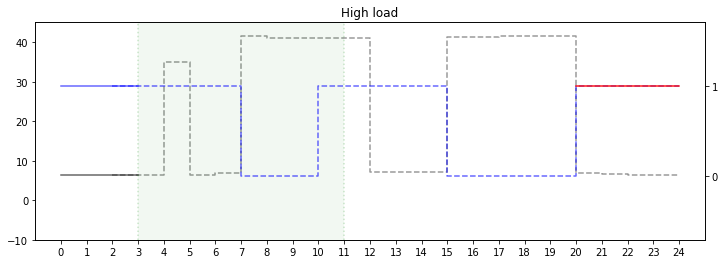

3h: [1, 1, 1, 1, 0, 0, 0, 1], False


Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.

Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.


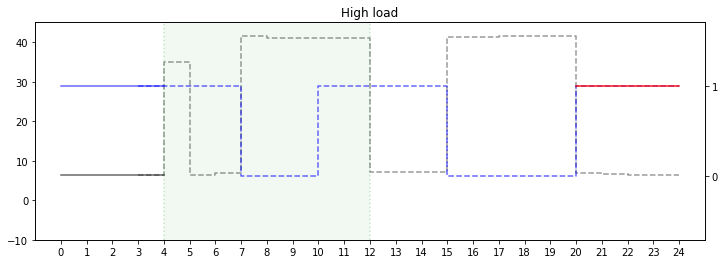

4h: [1, 1, 1, 0, 0, 0, 1, 1], False


Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.

Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.


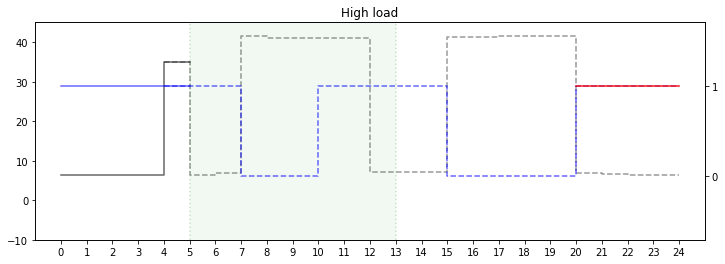

5h: [1, 1, 0, 0, 0, 1, 1, 1], False


Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.

Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.


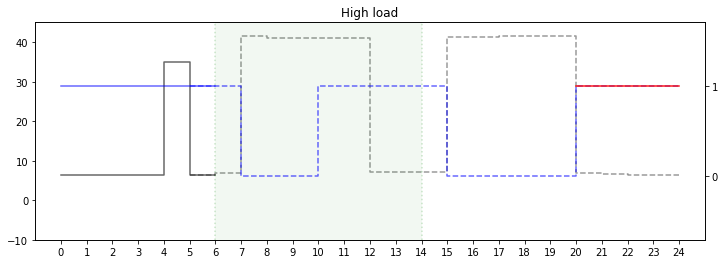

6h: [1, 0, 0, 0, 1, 1, 1, 1], False


Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.

Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.


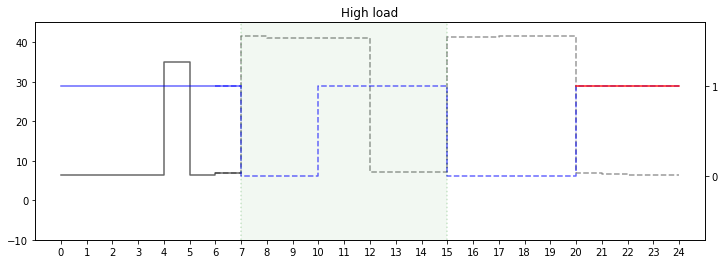

7h: [0, 0, 0, 1, 1, 1, 1, 1], False


Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.

Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.


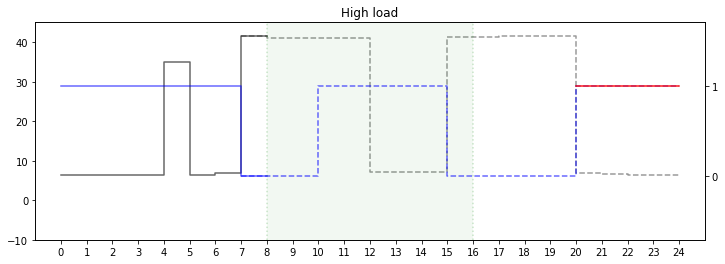

8h: [0, 0, 1, 1, 1, 1, 1, 0], False


Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.

Need to charge more before peak 15h-20h.
Current setting is to use normally off periods to charge.


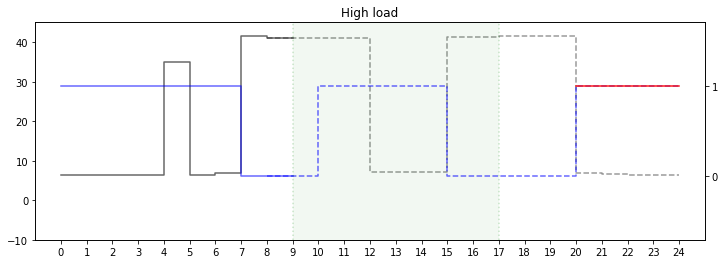

9h: [0, 1, 1, 1, 1, 1, 0, 0], False



In [6]:
# Scenario 3
c_el = [6.36, 6.34, 6.34, 6.4, 6.41, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
for iter in range(10):
    if iter==16:
        c_el = c_el + c_el
    if iter==3:
        c_el = [6.36, 6.34, 6.34, 6.41, 35, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 41.2, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
    sequence, two_options = get_sequence(c_el, m_load, iter)
    print(f"{iter}h: {sequence}, {two_options}\n")

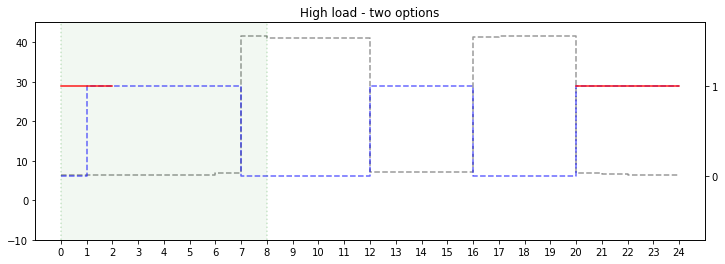

0h: [0, 1, 1, 1, 1, 1, 1, 0], True



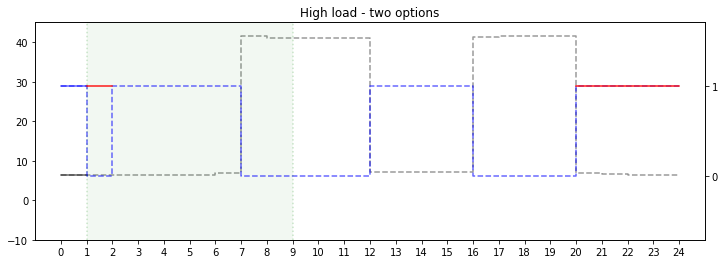

1h: [0, 1, 1, 1, 1, 1, 0, 0], True



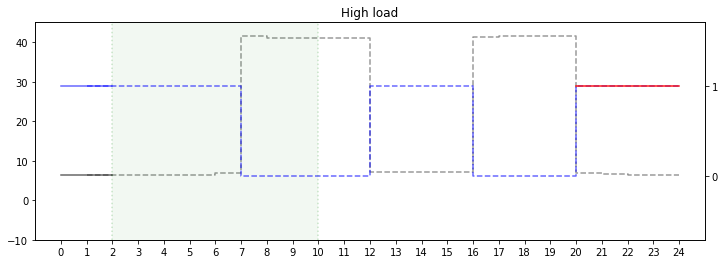

2h: [1, 1, 1, 1, 1, 0, 0, 0], False


Need to charge more before peak 7h-12h.
Current setting is to use normally off periods to charge.

Need to charge more before peak 17h-20h.
Current setting is to use normally off periods to charge.


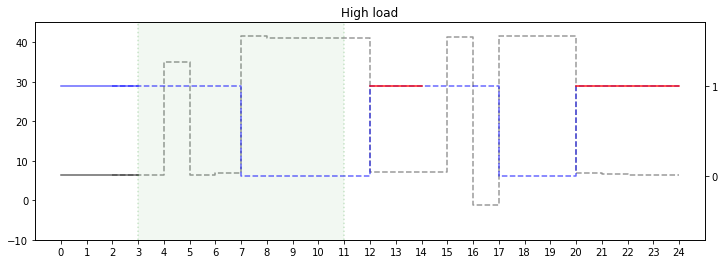

3h: [1, 1, 1, 1, 0, 0, 0, 0], False


Need to charge more before peak 17h-20h.
Current setting is to use normally off periods to charge.


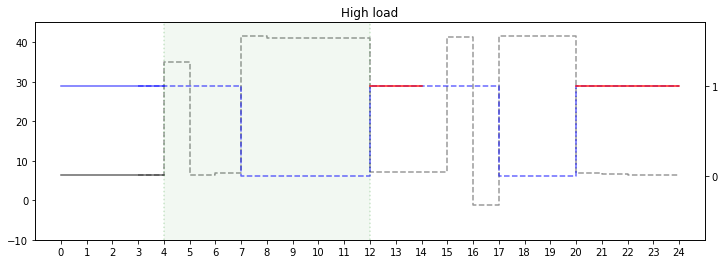

4h: [1, 1, 1, 0, 0, 0, 0, 0], False


Need to charge more before peak 17h-20h.
Current setting is to use normally off periods to charge.


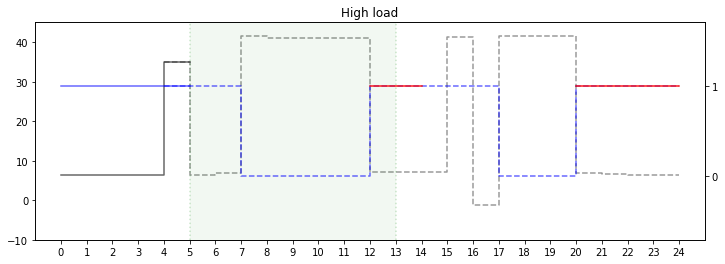

5h: [1, 1, 0, 0, 0, 0, 0, 1], False


Need to charge more before peak 17h-20h.
Current setting is to use normally off periods to charge.


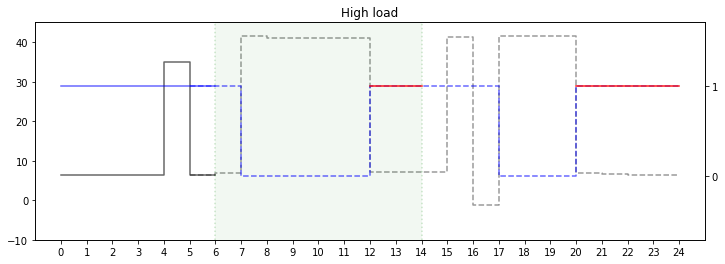

6h: [1, 0, 0, 0, 0, 0, 1, 1], False


Need to charge more before peak 17h-20h.
Current setting is to use normally off periods to charge.


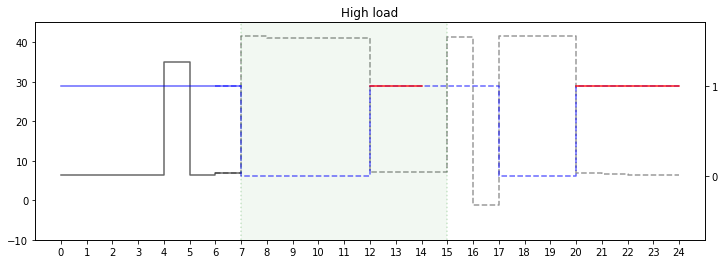

7h: [0, 0, 0, 0, 0, 1, 1, 1], False


Need to charge more before peak 17h-20h.
Current setting is to use normally off periods to charge.


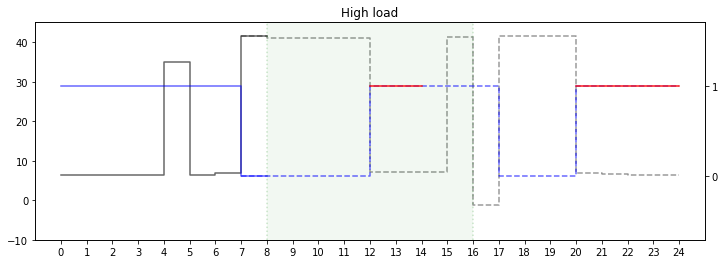

8h: [0, 0, 0, 0, 1, 1, 1, 1], False


Need to charge more before peak 17h-20h.
Current setting is to use normally off periods to charge.


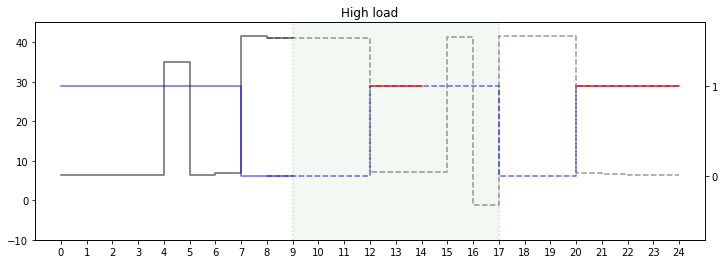

9h: [0, 0, 0, 1, 1, 1, 1, 1], False



In [7]:
# Scenario 4
c_el = [6.36, 6.34, 6.34, 6.4, 6.41, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
for iter in range(10):
    if iter==16:
        c_el = c_el + c_el
    if iter==3:
        c_el = [6.36, 6.34, 6.34, 6.41, 35, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 41.2, -1.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
    sequence, two_options = get_sequence(c_el, m_load, iter)
    print(f"{iter}h: {sequence}, {two_options}\n")